In [1]:
import sys
sys.path.append("..")

import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
from spiralcutter_advanced.libs.spiral_funcs import *
from spiralcutter_advanced.libs.profile_funcs import *
from spiralcutter_advanced.libs.helper_funcs import *
from scipy.optimize import curve_fit
from astropy.io import fits

0.18150605427730782
===
0.16231007479192194
0.06487153666239374
0.14919744173437238


(array([0., 0., 0., 0., 0., 2., 1., 2., 1., 1., 4., 4., 4., 5., 8., 4., 5.,
        6., 0., 2., 0., 1., 3., 1., 2., 1., 1., 0., 2., 0., 0., 0., 0., 0.,
        0., 0., 2., 0., 0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39]),
 <BarContainer object of 39 artists>)

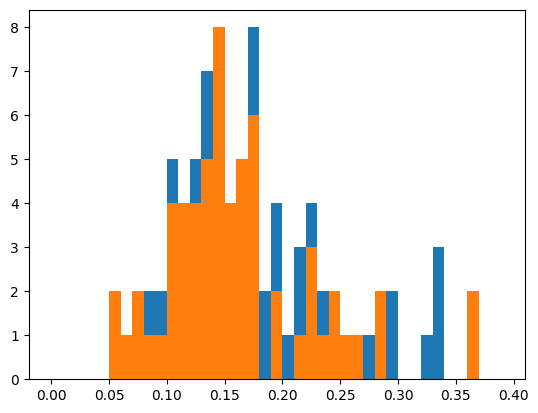

In [2]:
funcs_cat = [sp_o1, sp_o2, sp_o3, sp_o4, sp_o5, sp_o1_br1, sp_o2_br1, sp_o3_br1, sp_o1_br2, sp_o2_br2,
             arch_sp, arch_sp_o3, hyp_sp, hyp_sp_o3, sp_wave]
for i in range(len(funcs_cat)):
    funcs_cat[i] = funcs_cat[i].__name__
        
def find_arms_shapes():
    gal_paths = np.sort(glob.glob("../galaxies_images/*"))
    gal_list = []
    len_list = []
    func_list = []
    wdev_table = []
    bic_table = []
    errs_table = []
    Ns_table = []
    
    for path in gal_paths:
        path_wdev = f"{path}/spiral_params/wdevs.dat"
        path_bic = f"{path}/spiral_params/BICs.dat"
        gal = path.split("/")[-1]
        
        with open(path_wdev, "r") as file:
            for line in file:
                col, fname, phi0, phie, err_frac = line.split()[0:5]
                phi0 = float(phi0)
                phie = float(phie)
                err_frac = float(err_frac)
                length = np.abs(phie - phi0)
                
                wdevs = line.split("[")[1].split("]")[0]
                wdevs = np.array(wdevs.split()).astype(float)
                
                gal_list.append(gal)
                len_list.append(length)
                func_list.append(fname)
                wdev_table.append(wdevs)
                errs_table.append(err_frac)
        
        with open(path_bic, "r") as file:
            for line in file:
                N_dots = float(line.split()[4])
                bic = line.split("[")[1].split("]")[0]
                bic = np.array(bic.split()).astype(float)
                bic_table.append(bic)
                Ns_table.append(N_dots)
    
    gal_list = np.array(gal_list)
    len_list = np.array(len_list)
    func_list = np.array(func_list)
    wdev_table = np.array(wdev_table)
    bic_table = np.array(bic_table)
    errs_table = np.array(errs_table)
    Ns_table = np.array(Ns_table)
    
    return gal_list, len_list, func_list, wdev_table, bic_table, errs_table, Ns_table
    
gal_list, len_list, func_list, wdev_table, bic_table, errs_table, Ns_table = find_arms_shapes()

bic_abs_table = bic_table * np.array([Ns_table] * 15).T

print(np.mean(errs_table))
print("===")
print(np.mean(errs_table[len_list > 90]))
print(np.std(errs_table[len_list > 90]))
print(np.median(errs_table[len_list > 90]))
plt.hist(errs_table, bins = np.arange(0, 0.4, 0.01))
plt.hist(errs_table[len_list > 90], bins = np.arange(0, 0.4, 0.01))

In [3]:
np.shape(bic_table)

pars_n = np.array([1, 2, 3, 4, 5, 3, 5, 7, 5, 8])

bic_tr = bic_abs_table[:, :10] #o1...o5, o1b1...o3b1, o1b2, o2b2

#plt.scatter(wdev_table[:, 4], wdev_table[:, 6], c = "b", s = 5) #o5 vs o2b1
#plt.plot([0, 0.3], [0, 0.3], ls = "--", c = "k")

funcs_cat = np.array(funcs_cat)
num_good = np.zeros_like(bic_tr)

for i in range(len(len_list)):
    len_arm = len_list[i]
    bic = bic_tr[i]
    arm = gal_list[i]
    best_bic = np.nanmin(bic)
    i_good = (bic < best_bic + 2)
    pn_max = np.max(pars_n[i_good])
    #print(pn_max)
    i_nof = (pars_n <= pn_max)
    num_good[i, :] = i_nof
    #print(arm)
    #print(funcs_cat[i_good])

medium = len_list > 90
long = len_list > 180
longest = len_list > 360

print(funcs_cat[:10])
print(np.sum(num_good[~medium], axis = 0), np.sum(~medium))
print(np.sum(num_good[medium * ~long], axis = 0), np.sum(medium * ~long))
print(np.sum(num_good[long * ~longest], axis = 0), np.sum(long * ~longest))
print(np.sum(num_good[longest], axis = 0), np.sum(longest))

print(13 / np.sum(long))
print(np.sum(long))

['sp_o1' 'sp_o2' 'sp_o3' 'sp_o4' 'sp_o5' 'sp_o1_br1' 'sp_o2_br1'
 'sp_o3_br1' 'sp_o1_br2' 'sp_o2_br2']
[26. 26.  7.  2.  1.  7.  1.  0.  1.  0.] 26
[27. 27. 24. 16. 11. 24. 11.  3. 11.  3.] 27
[23. 23. 22. 20. 20. 22. 20. 14. 20.  6.] 23
[12. 12. 12. 12. 12. 12. 12. 12. 12.  5.] 12
0.37142857142857144
35


long spiral arms (>180): 35
all spiral arms (>90): 62
spurs (<90): 26
bendings in spiral arms: 0.35
bendings in long spiral arms: 0.6
highest avg dev
1.2842166
0.51885684
0.44811106
0.43524682
0.37198257
arch3 max:
1.29651832
log sp fitting spurs
0.92
N = 2 fitting spurs
1.0
N = 2 and log sp ratio for spurs
0.76
log sp fitting spiral arms
0.23
log sp fitting short spiral arms
0.44
N = 3 fitting short spiral arms
0.93
log sp fitting long spiral arms
0.04
N = 3 fitting long spiral arms
0.7
N = 4 fitting long spiral arms
0.83
N = 4 or o2b1 fitting long spiral arms
0.96
log sp fitting longest spiral arms
0.08
N = 3 fitting longest spiral arms
0.33
N = 4 fitting longest spiral arms
0.67
N = 4 or o3b1 or o2b2 fitting longest spiral arms
1.0


/tmp/ipykernel_1284/3854238933.py:106: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


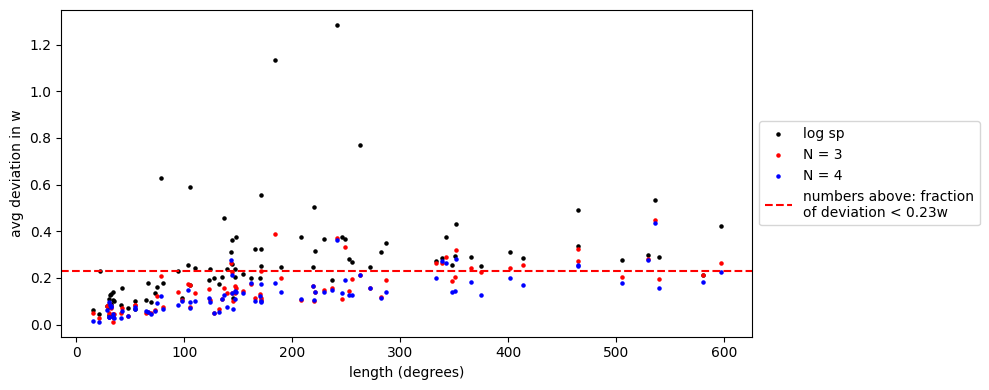

In [27]:
breaks = (func_list == "sp_o1_br1") + (func_list == "sp_o2_br1") + (func_list == "sp_o3_br1") + (func_list == "sp_o1_br2") + (func_list == "sp_o2_br2")

#print(func_list)

medium = len_list > 90
long = len_list > 180
longest = len_list > 360

print(f"long spiral arms (>180): {np.sum(long)}")
print(f"all spiral arms (>90): {np.sum(medium)}")
print(f"spurs (<90): {np.sum(~medium)}")

print(f"bendings in spiral arms: {np.round(np.sum(medium * breaks) / np.sum(medium), 2)}")
print(f"bendings in long spiral arms: {np.round(np.sum(long * breaks) / np.sum(long), 2)}")

#print(gal_list[long])

thr = 0.23

logsp_good = np.round(np.sum(medium * (wdev_table[:, 0] < thr)) / np.sum(medium), 2)
logsp_long_good = np.round(np.sum(long * (wdev_table[:, 0] < thr)) / np.sum(long), 2)
logsp_spur_good = np.round(np.sum(~medium * (wdev_table[:, 0] < thr)) / np.sum(~medium), 2)
logsp_nb_good = np.round(np.sum(medium * ~breaks * (wdev_table[:, 0] < thr)) / np.sum(medium * ~breaks), 2)
o2_good = np.round(np.sum(medium * ~breaks * (wdev_table[:, 1] < thr)) / np.sum(medium * ~breaks), 2)
o2_all_good = np.round(np.sum(medium * (wdev_table[:, 1] < thr)) / np.sum(medium), 2)
o3_good = np.round(np.sum(medium * ~breaks * (wdev_table[:, 2] < thr)) / np.sum(medium * ~breaks), 2)
o3_all_good = np.round(np.sum(medium * (wdev_table[:, 2] < thr)) / np.sum(medium), 2)
o3_l_good = np.round(np.sum(long * ~breaks * (wdev_table[:, 2] < thr)) / np.sum(long * ~breaks), 2)
o4_all_good = np.round(np.sum(medium * (wdev_table[:, 3] < thr)) / np.sum(medium), 2)
o2b1_good = np.round(np.sum(breaks * (wdev_table[:, 6] < thr)) / np.sum(breaks), 2)

"""
print("o2 good spurs")
print(np.round(np.sum(~medium * (wdev_table[:, 1] < thr)) / np.sum(~medium), 2))
print()
"""
print("highest avg dev")
print(np.nanmax(wdev_table[:, 0]))
print(np.nanmax(wdev_table[:, 1]))
print(np.nanmax(wdev_table[:, 2]))
print(np.nanmax(wdev_table[:, 3]))
print(np.nanmax(wdev_table[:, 4]))
print("arch3 max:")
print(np.nanmax(wdev_table[:, 10]))


print("log sp fitting spurs")
print(np.round(np.sum(~medium * (wdev_table[:, 0] < thr)) / np.sum(~medium), 2))
print("N = 2 fitting spurs")
print(np.round(np.sum(~medium * (wdev_table[:, 1] < thr)) / np.sum(~medium), 2))
print("N = 2 and log sp ratio for spurs")
print(np.round(np.mean(wdev_table[~medium, 1] / wdev_table[~medium, 0]), 2))
print("======")
print("log sp fitting spiral arms")
print(np.round(np.sum(medium * (wdev_table[:, 0] < thr)) / np.sum(medium), 2))
print("======")
print("log sp fitting short spiral arms")
print(np.round(np.sum(medium * ~long * (wdev_table[:, 0] < thr)) / np.sum(medium * ~long), 2))
print("N = 3 fitting short spiral arms")
print(np.round(np.sum(medium * ~long * (wdev_table[:, 2] < thr)) / np.sum(medium * ~long), 2))
print("======")
print("log sp fitting long spiral arms")
print(np.round(np.sum(long * ~longest * (wdev_table[:, 0] < thr)) / np.sum(long * ~longest), 2))
print("N = 3 fitting long spiral arms")
print(np.round(np.sum(long * ~longest * (wdev_table[:, 2] < thr)) / np.sum(long * ~longest), 2))
print("N = 4 fitting long spiral arms")
print(np.round(np.sum(long * ~longest * (wdev_table[:, 3] < thr)) / np.sum(long * ~longest), 2))
print("N = 4 or o2b1 fitting long spiral arms")
print(np.round(np.sum(long * ~longest * ((wdev_table[:, 3] < thr) + (wdev_table[:, 6] < thr))) / np.sum(long * ~longest), 2))
print("======")
print("log sp fitting longest spiral arms")
print(np.round(np.sum(longest * (wdev_table[:, 0] < thr)) / np.sum(longest), 2))
print("N = 3 fitting longest spiral arms")
print(np.round(np.sum(longest * (wdev_table[:, 2] < thr)) / np.sum(longest), 2))
print("N = 4 fitting longest spiral arms")
print(np.round(np.sum(longest * (wdev_table[:, 3] < thr)) / np.sum(longest), 2))
print("N = 4 or o3b1 or o2b2 fitting longest spiral arms")
print(np.round(np.sum(longest * ((wdev_table[:, 3] < thr) + (wdev_table[:, 7] < thr) + (wdev_table[:, 7] < thr))) / np.sum(longest), 2))
#print(medium * ~long * breaks)
#print("N = 4 fitting spiral arms")
#print(np.round(np.sum(medium * (wdev_table[:, 3] < thr)) / np.sum(medium), 2))

fig, ax = plt.subplots(figsize=[10, 4])

ax.scatter(len_list, wdev_table[:, 0], c = "k", s = 5, label = f"log sp")
ax.scatter(len_list, wdev_table[:, 2], c = "r", s = 5, label = f"N = 3")
ax.scatter(len_list, wdev_table[:, 3], c = "b", s = 5, label = f"N = 4")
#ax.scatter([], [], c = "w", s = 5, label = f"log sp long, {logsp_long_good}")
#ax.scatter([], [], c = "w", s = 5, label = f"log sp spurs, {logsp_spur_good}")
#ax.scatter([], [], c = "w", s = 5, label = f"log sp no bends, {logsp_nb_good}")
#ax.scatter([], [], c = "w", s = 5, label = f"o2, {o2_good}")
#ax.scatter([], [], c = "w", s = 5, label = f"o2 incl. bends, {o2_all_good}")
#ax.scatter(len_list[~breaks], wdev_table[~breaks, 2], c = "r", s = 5, label = f"o3, {o3_good}")
#ax.scatter(len_list[breaks], wdev_table[breaks, 2], c = "g", marker = "x", s = 5)
#ax.scatter([], [], c = "w", s = 5, label = f"o3 incl. bends, {o3_all_good}")
#ax.scatter([], [], c = "w", s = 5, label = f"o3 long, {o3_l_good}")
#ax.scatter([], [], c = "w", s = 5, label = f"o4 incl. bends, {o4_all_good}")
#ax.scatter(len_list[breaks], wdev_table[breaks, 6], c = "b", s = 5, label = f"o2b1, {o2b1_good}")
ax.axhline(thr, label = f"numbers above: fraction\nof deviation < {thr}w", ls = "--", c = "r")

ax.legend(bbox_to_anchor=[1, 0.5], loc = "center left")
ax.set_xlabel("length (degrees)")
ax.set_ylabel("avg deviation in w")

fig.tight_layout()
fig.show()

In [33]:
thr = 0.23
print("log sp fitting arms")
print(f"{np.round(np.sum(medium * (wdev_table[:, 0] < thr)) * 100 / np.sum(medium))} %")
print(np.round(np.mean(wdev_table[medium, 0]), 2))
print("arch sp fitting arms")
print(f"{np.round(np.sum(medium * (wdev_table[:, 10] < thr)) * 100 / np.sum(medium))} %")
print(np.round(np.mean(wdev_table[medium, 10]), 2))
print("hyp sp fitting arms")
print(f"{np.round(np.sum(medium * (wdev_table[:, 12] < thr)) * 100 / np.sum(medium))} %")
print(np.round(np.mean(wdev_table[medium, 12]), 2))

print("======")
print("o3 fitting arms")
print(f"{np.round(np.sum(medium * (wdev_table[:, 2] < thr)) * 100 / np.sum(medium))} %")
print(np.round(np.mean(wdev_table[medium, 2]), 3))
print("arch3 sp fitting arms")
print(f"{np.round(np.sum(medium * (wdev_table[:, 11] < thr)) * 100 / np.sum(medium))} %")
print(np.round(np.mean(wdev_table[medium, 11]), 3))
print("hyp3 sp fitting arms")
print(f"{np.round(np.sum(medium * (wdev_table[:, 13] < thr)) * 100 / np.sum(medium))} %")
print(np.round(np.nanmean(wdev_table[medium, 13]), 3))
print()
print("wave sp fitting arms")
print(f"{np.round(np.sum(medium * (wdev_table[:, 14] < thr)) * 100 / np.sum(medium))} %")
print(np.round(np.nanmean(wdev_table[medium, 14]), 3))
print("o4 fitting arms")
print(f"{np.round(np.sum(medium * (wdev_table[:, 3] < thr)) * 100 / np.sum(medium))} %")
print(np.round(np.mean(wdev_table[medium, 3]), 3))

log sp fitting arms
23.0 %
0.34
arch sp fitting arms
27.0 %
0.42
hyp sp fitting arms
15.0 %
1.22
o3 fitting arms
73.0 %
0.189
arch3 sp fitting arms
74.0 %
0.186
hyp3 sp fitting arms
27.0 %
1.32

wave sp fitting arms
71.0 %
0.169
o4 fitting arms
85.0 %
0.16


In [34]:
print(np.round(np.mean(wdev_table[long * ~longest, 0]), 2))
print(np.round(np.mean(wdev_table[longest, 0]), 2))

0.42
0.33


# old materials

long (>180): 35
medium (>90): 62
spurs (<90): 26
bendings in long: 0.6285714285714286
bendings in medium: 0.037037037037037035
o2 good spurs
1.0

1.2842166
0.51885684
0.44811106
0.43524682
0.37198257


/tmp/ipykernel_24182/1055731231.py:59: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


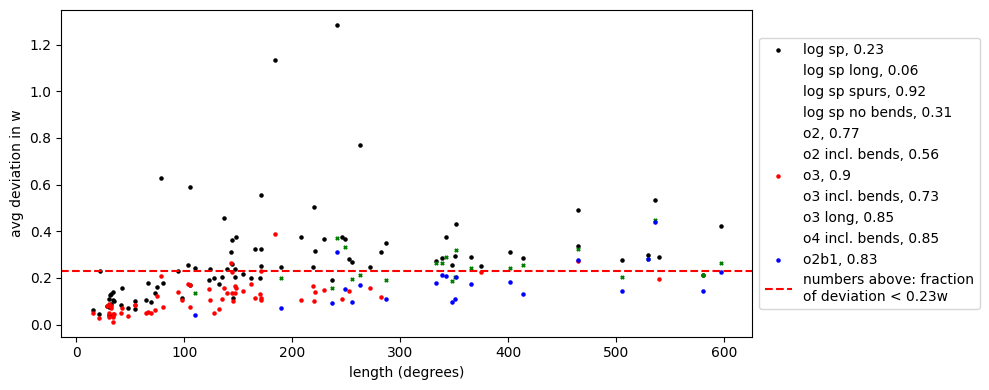

In [5]:
breaks = (func_list == "sp_o2_br1") + (func_list == "sp_o3_br1") + (func_list == "sp_o2_br2")
medium = len_list > 90
long = len_list > 180

fig, ax = plt.subplots(figsize=[10, 4])

print(f"long (>180): {np.sum(long)}")
print(f"medium (>90): {np.sum(medium)}")
print(f"spurs (<90): {np.sum(~medium)}")
print(f"bendings in long: {np.sum(long * breaks) / np.sum(long)}")
print(f"bendings in medium: {np.sum(medium * ~long * breaks) / np.sum(medium * ~long)}")

#print(gal_list[long])

thr = 0.23

logsp_good = np.round(np.sum(medium * (wdev_table[:, 0] < thr)) / np.sum(medium), 2)
logsp_long_good = np.round(np.sum(long * (wdev_table[:, 0] < thr)) / np.sum(long), 2)
logsp_spur_good = np.round(np.sum(~medium * (wdev_table[:, 0] < thr)) / np.sum(~medium), 2)
logsp_nb_good = np.round(np.sum(medium * ~breaks * (wdev_table[:, 0] < thr)) / np.sum(medium * ~breaks), 2)
o2_good = np.round(np.sum(medium * ~breaks * (wdev_table[:, 1] < thr)) / np.sum(medium * ~breaks), 2)
o2_all_good = np.round(np.sum(medium * (wdev_table[:, 1] < thr)) / np.sum(medium), 2)
o3_good = np.round(np.sum(medium * ~breaks * (wdev_table[:, 2] < thr)) / np.sum(medium * ~breaks), 2)
o3_all_good = np.round(np.sum(medium * (wdev_table[:, 2] < thr)) / np.sum(medium), 2)
o3_l_good = np.round(np.sum(long * ~breaks * (wdev_table[:, 2] < thr)) / np.sum(long * ~breaks), 2)
o4_all_good = np.round(np.sum(medium * (wdev_table[:, 3] < thr)) / np.sum(medium), 2)
o2b1_good = np.round(np.sum(breaks * (wdev_table[:, 6] < thr)) / np.sum(breaks), 2)

print("o2 good spurs")
print(np.round(np.sum(~medium * (wdev_table[:, 1] < thr)) / np.sum(~medium), 2))
print()

print(np.nanmax(wdev_table[:, 0]))
print(np.nanmax(wdev_table[:, 1]))
print(np.nanmax(wdev_table[:, 2]))
print(np.nanmax(wdev_table[:, 3]))
print(np.nanmax(wdev_table[:, 4]))

ax.scatter(len_list, wdev_table[:, 0], c = "k", s = 5, label = f"log sp, {logsp_good}")
ax.scatter([], [], c = "w", s = 5, label = f"log sp long, {logsp_long_good}")
ax.scatter([], [], c = "w", s = 5, label = f"log sp spurs, {logsp_spur_good}")
ax.scatter([], [], c = "w", s = 5, label = f"log sp no bends, {logsp_nb_good}")
ax.scatter([], [], c = "w", s = 5, label = f"o2, {o2_good}")
ax.scatter([], [], c = "w", s = 5, label = f"o2 incl. bends, {o2_all_good}")
ax.scatter(len_list[~breaks], wdev_table[~breaks, 2], c = "r", s = 5, label = f"o3, {o3_good}")
ax.scatter(len_list[breaks], wdev_table[breaks, 2], c = "g", marker = "x", s = 5)
ax.scatter([], [], c = "w", s = 5, label = f"o3 incl. bends, {o3_all_good}")
ax.scatter([], [], c = "w", s = 5, label = f"o3 long, {o3_l_good}")
ax.scatter([], [], c = "w", s = 5, label = f"o4 incl. bends, {o4_all_good}")
ax.scatter(len_list[breaks], wdev_table[breaks, 6], c = "b", s = 5, label = f"o2b1, {o2b1_good}")
ax.axhline(thr, label = f"numbers above: fraction\nof deviation < {thr}w", ls = "--", c = "r")
#ax.scatter(len_list, wdev_sel, c = "g", s = 5)

ax.legend(bbox_to_anchor=[1, 0.5], loc = "center left")
ax.set_xlabel("length (degrees)")
ax.set_ylabel("avg deviation in w")

fig.tight_layout()
fig.show()

long (>180): 35
medium (>90): 62
spurs (<90): 26
bendings in long: 0.6
bendings in medium: 0.037037037037037035
1.2842166
0.51885684
0.44811106
0.43524682
0.37198257


/tmp/ipykernel_1284/19047157.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


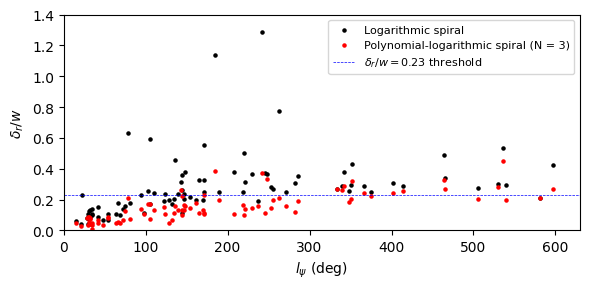

In [57]:
breaks = (func_list == "sp_o2_br1") + (func_list == "sp_o3_br1") + (func_list == "sp_o2_br2")
medium = len_list > 90
long = len_list > 180

fig, ax = plt.subplots(figsize=[6, 3])

print(f"long (>180): {np.sum(long)}")
print(f"medium (>90): {np.sum(medium)}")
print(f"spurs (<90): {np.sum(~medium)}")
print(f"bendings in long: {np.sum(long * breaks) / np.sum(long)}")
print(f"bendings in medium: {np.sum(medium * ~long * breaks) / np.sum(medium * ~long)}")

#print(gal_list[long])

logsp_good = np.round(np.sum(medium * (wdev_table[:, 0] < 0.2)) / np.sum(medium), 2)
logsp_long_good = np.round(np.sum(long * (wdev_table[:, 0] < 0.2)) / np.sum(long), 2)
logsp_spur_good = np.round(np.sum(~medium * (wdev_table[:, 0] < 0.2)) / np.sum(~medium), 2)
logsp_nb_good = np.round(np.sum(medium * ~breaks * (wdev_table[:, 0] < 0.2)) / np.sum(medium * ~breaks), 2)
o2_good = np.round(np.sum(medium * ~breaks * (wdev_table[:, 1] < 0.2)) / np.sum(medium * ~breaks), 2)
o2_all_good = np.round(np.sum(medium * (wdev_table[:, 1] < 0.2)) / np.sum(medium), 2)
o3_good = np.round(np.sum(medium * ~breaks * (wdev_table[:, 2] < 0.2)) / np.sum(medium * ~breaks), 2)
o3_all_good = np.round(np.sum(medium * (wdev_table[:, 2] < 0.2)) / np.sum(medium), 2)
o3_l_good = np.round(np.sum(long * ~breaks * (wdev_table[:, 2] < 0.2)) / np.sum(long * ~breaks), 2)
o4_all_good = np.round(np.sum(medium * (wdev_table[:, 3] < 0.2)) / np.sum(medium), 2)
o2b1_good = np.round(np.sum(breaks * (wdev_table[:, 6] < 0.2)) / np.sum(breaks), 2)

print(np.nanmax(wdev_table[:, 0]))
print(np.nanmax(wdev_table[:, 1]))
print(np.nanmax(wdev_table[:, 2]))
print(np.nanmax(wdev_table[:, 3]))
print(np.nanmax(wdev_table[:, 4]))

ax.scatter(len_list, wdev_table[:, 0], c = "k", s = 5, label = f"Logarithmic spiral")
ax.scatter(len_list, wdev_table[:, 2], c = "r", s = 5, label = f"Polynomial-logarithmic spiral (N = 3)")
ax.axhline(0.23, label = "$\delta_r / w = 0.23$ threshold", ls = "--", lw = 0.5, c = "b")
#ax.axhline(0.55, ls = ":", lw = 0.5, c = "m")
#ax.axvline(100, ls = ":", lw = 0.5, c = "m")
#ax.axvline(300, ls = ":", lw = 0.5, c = "m")
#ax.scatter(len_list, wdev_sel, c = "g", s = 5)

#ax.legend(bbox_to_anchor=[1, 0.5], loc = "center left")
ax.legend(fontsize=8)
ax.set_xlabel("$l_\psi$ (deg)")
ax.set_ylabel("$\delta_r / w$")
ax.set_xlim(0, 630)
ax.set_ylim(0, 1.4)

fig.tight_layout()
fig.savefig("../images/selected/deltaw_lpsi")
fig.show()

In [59]:
print(np.nanmax(wdev_table[len_list >= 300, 0]))
print(np.nanmean(wdev_table[len_list >= 300, 0]))
print(np.sum(len_list >= 300))
print()
print(np.sum(wdev_table[(len_list < 300) * (len_list >= 100), 0] > 0.55))
print(np.sum((len_list < 300) * (len_list >= 100)))
print(np.nanmean(wdev_table[(len_list < 300) * (len_list >= 100), 0]))

0.53538937
0.32886502777777776
18

5
42
0.3461535880952381


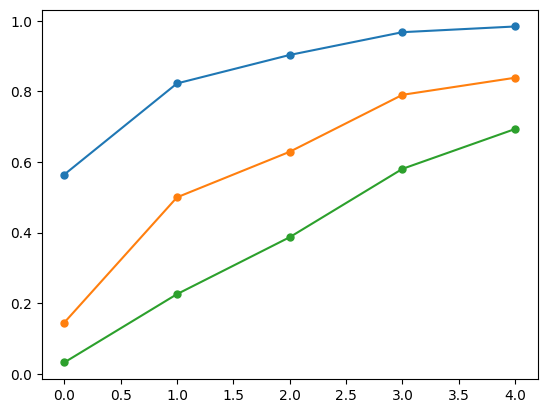

In [59]:
fg03 = np.sum((wdev_table[medium, :5] < 0.3), axis = 0) / np.sum(medium)
fg02 = np.sum((wdev_table[medium, :5] < 0.2), axis = 0) / np.sum(medium)
fg015 = np.sum((wdev_table[medium, :5] < 0.15), axis = 0) / np.sum(medium)

plt.plot(fg03, marker = "o", ms = 5)
plt.plot(fg02, marker = "o", ms = 5)
plt.plot(fg015, marker = "o", ms = 5)

['sp_o1' 'sp_o2' 'sp_o3' 'sp_o4' 'sp_o5' 'sp_o1_br1' 'sp_o2_br1'
 'sp_o3_br1' 'sp_o1_br2' 'sp_o2_br2']
[26. 26.  7.  2.  1.  7.  1.  0.  1.  0.] 26
[27. 27. 24. 16. 11. 24. 11.  3. 11.  3.] 27
[23. 23. 22. 20. 20. 22. 20. 14. 20.  6.] 23
[12. 12. 12. 12. 12. 12. 12. 12. 12.  5.] 12


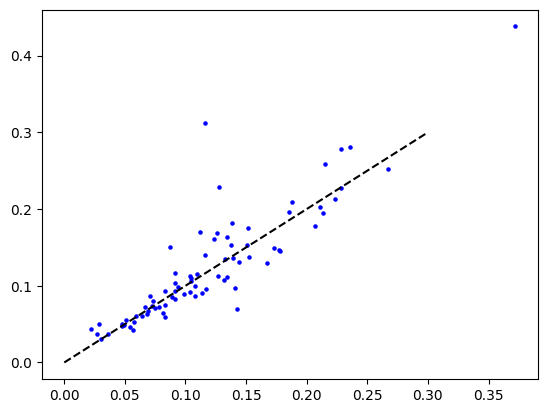

In [33]:
np.shape(bic_table)

pars_n = np.array([1, 2, 3, 4, 5, 3, 5, 7, 5, 8])

bic_tr = bic_abs_table[:, :10] #o1...o5, o1b1...o3b1, o1b2, o2b2

plt.scatter(wdev_table[:, 4], wdev_table[:, 6], c = "b", s = 5) #o5 vs o2b1
plt.plot([0, 0.3], [0, 0.3], ls = "--", c = "k")

funcs_cat = np.array(funcs_cat)
num_good = np.zeros_like(bic_tr)

for i in range(len(len_list)):
    len_arm = len_list[i]
    bic = bic_tr[i]
    arm = gal_list[i]
    best_bic = np.nanmin(bic)
    i_good = (bic < best_bic + 2)
    pn_max = np.max(pars_n[i_good])
    #print(pn_max)
    i_nof = (pars_n <= pn_max)
    num_good[i, :] = i_nof
    #print(arm)
    #print(funcs_cat[i_good])

medium = len_list > 90
long = len_list > 180
longest = len_list > 360

print(funcs_cat[:10])
print(np.sum(num_good[~medium], axis = 0), np.sum(~medium))
print(np.sum(num_good[medium * ~long], axis = 0), np.sum(medium * ~long))
print(np.sum(num_good[long * ~longest], axis = 0), np.sum(long * ~longest))
print(np.sum(num_good[longest], axis = 0), np.sum(longest))

/tmp/ipykernel_51919/4172620576.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend()
/tmp/ipykernel_51919/4172620576.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend()
/tmp/ipykernel_51919/4172620576.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend()
/tmp/ipykernel_51919/4172620576.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend()
/tmp/ipykernel_51919/4172620576.py:50: UserWarning: FigureCanvasAgg is non-interactive, and 

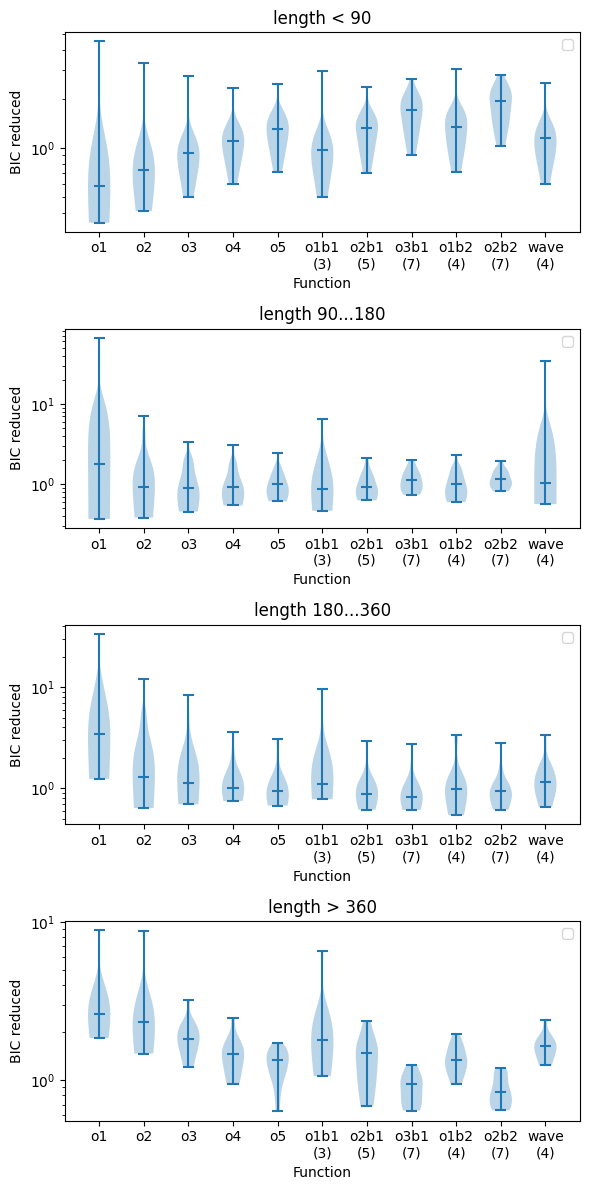

In [61]:
def cut_nans(data):
    mask = ~np.isnan(data)
    filtered_data = [d[m] for d, m in zip(data.T, mask.T)]
    return filtered_data

breaks = (func_list == "sp_o2_br1") + (func_list == "sp_o3_br1") + (func_list == "sp_o2_br2")
medium = len_list > 90
long = len_list > 180
longest = len_list > 360

r_fs = np.zeros_like(bic_table[0, :]).astype(bool)
r_fs[:10] = True
r_fs[-1] = True

fig, axs = plt.subplots(figsize=[6, 12], nrows = 4)

options = ["< 90", "90...180", "180...360", "> 360"]
samps = [~medium, medium * ~long, long * ~longest, longest]

for i in range(len(options)):
    opt = options[i]
    samp = samps[i]
    
    data = cut_nans(bic_table[samp][:, r_fs])
    data_b = cut_nans(bic_table[samp * breaks][:, r_fs])
    data_nb = cut_nans(bic_table[samp * ~breaks][:, r_fs])
    
    try:
        axs[i].violinplot(data, showmedians = True)#, side = "low")
    except Exception:
        pass
    
    #try:
    #    axs[i].violinplot(data_b, showmedians = True, side = "high")
    #except Exception:
    #    pass
    
    #axs[i].plot([], [], c = "C0", label = "no bend")
    #axs[i].plot([], [], c = "C1", label = "with bend(s)")

    axs[i].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
    axs[i].set_xticklabels(["o1", "o2", "o3", "o4", "o5", "o1b1\n(3)", "o2b1\n(5)", "o3b1\n(7)",
                            "o1b2\n(4)", "o2b2\n(7)", "wave\n(4)"])
    axs[i].set_xlabel("Function")
    axs[i].set_ylabel("BIC reduced")
    axs[i].set_yscale("log")
    axs[i].set_title(f"length {opt}")
    axs[i].legend()
fig.tight_layout()
fig.show()

/tmp/ipykernel_51919/3114111150.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend()
/tmp/ipykernel_51919/3114111150.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend()
/tmp/ipykernel_51919/3114111150.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend()
/tmp/ipykernel_51919/3114111150.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend()
/tmp/ipykernel_51919/3114111150.py:50: UserWarning: FigureCanvasAgg is non-interactive, and 

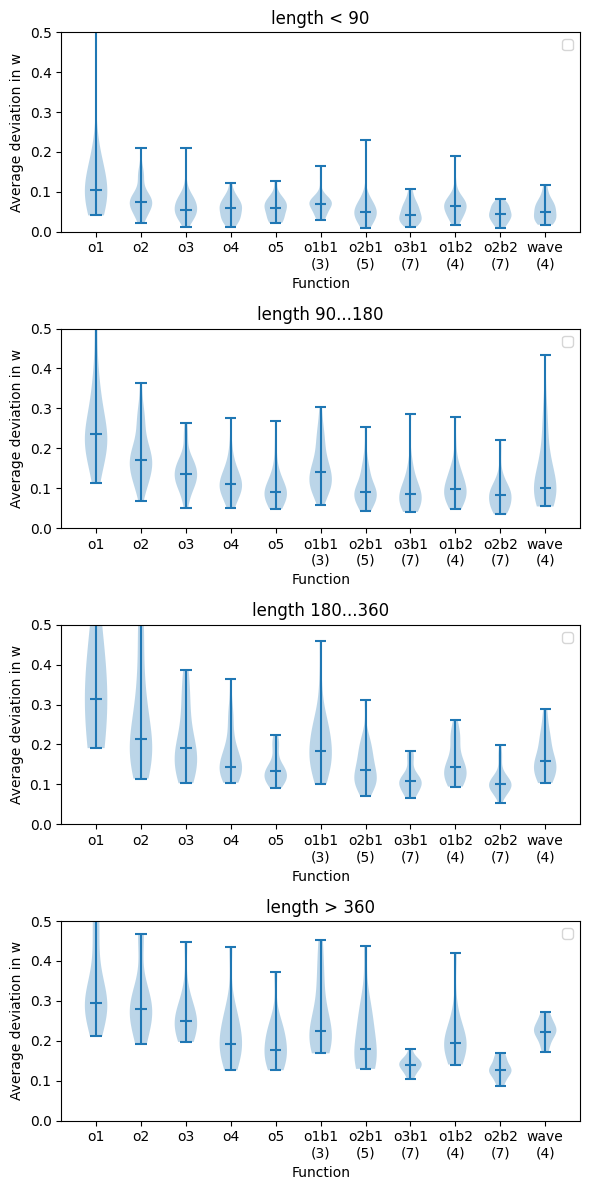

In [64]:
def cut_nans(data):
    mask = np.isfinite(data)
    filtered_data = [d[m] for d, m in zip(data.T, mask.T)]
    return filtered_data

breaks = (func_list == "sp_o2_br1") + (func_list == "sp_o3_br1") + (func_list == "sp_o2_br2")
medium = len_list > 90
long = len_list > 180
longest = len_list > 360

r_fs = np.zeros_like(bic_table[0, :]).astype(bool)
r_fs[:10] = True
r_fs[-1] = True

fig, axs = plt.subplots(figsize=[6, 12], nrows = 4)

options = ["< 90", "90...180", "180...360", "> 360"]
samps = [~medium, medium * ~long, long * ~longest, longest]

for i in range(len(options)):
    opt = options[i]
    samp = samps[i]
    
    data = cut_nans(wdev_table[samp][:, r_fs])
    data_b = cut_nans(wdev_table[samp * breaks][:, r_fs])
    data_nb = cut_nans(wdev_table[samp * ~breaks][:, r_fs])
    
    try:
        axs[i].violinplot(data, showmedians = True)#, side = "low")
    except Exception:
        pass
    
    #try:
    #    axs[i].violinplot(data_b, showmedians = True, side = "high")
    #except Exception:
    #    pass
    
    #axs[i].plot([], [], c = "C0", label = "no bend")
    #axs[i].plot([], [], c = "C1", label = "with bend(s)")

    axs[i].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
    axs[i].set_xticklabels(["o1", "o2", "o3", "o4", "o5", "o1b1\n(3)", "o2b1\n(5)", "o3b1\n(7)",
                            "o1b2\n(4)", "o2b2\n(7)", "wave\n(4)"])
    axs[i].set_xlabel("Function")
    axs[i].set_ylabel("Average deviation in w")
    axs[i].set_title(f"length {opt}")
    axs[i].set_ylim(0, 0.5)
    axs[i].legend()
fig.tight_layout()
fig.show()

/tmp/ipykernel_51919/1935102519.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_51919/1935102519.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


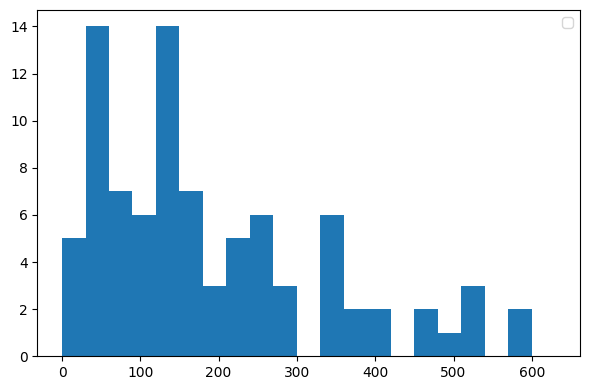

In [63]:
fig, ax = plt.subplots(figsize=[6, 4])

ax.hist(len_list, np.arange(0, 660, 30), density=False, ec="black", fc="b")

ax.legend()

fig.tight_layout()
fig.show()